# Understanding EigenFaces: Face Generation with PCA
 
 This notebook demonstrates how to use Principal Component Analysis (PCA) for dimensionality reduction in face generation. This is part 1 of a two-part series that combines PCA and Gaussian Mixture Models (GMM) to generate realistic face images.

 ## Introduction

 In this project, we explore how to generate realistic human faces using dimensionality reduction and probabilistic modeling. The technique we'll explore, known as EigenFaces, has been fundamental in computer vision and continues to provide insights into how we can represent and generate facial images.

### Why PCA Works for Faces

 Human faces, despite their complexity, share common patterns:
  - Eyes are always in roughly the same position
  - Noses are centered
  - Mouths are below noses

 PCA capitalizes on these patterns by:
  1. Finding common face features (eigenfaces)
  2. Representing each face as a combination of these features
  3. Reducing thousands of pixels to just a few hundred meaningful components

## Import Libraries

In [53]:
from sklearn.datasets import fetch_lfw_people
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

## Understanding the Dataset: Labeled Faces in the Wild (LFW)

 The Labeled Faces in the Wild (LFW) dataset is a collection of face photographs designed for studying unconstrained face recognition. Key characteristics include:
  - Aligned faces using face detection
  - Multiple images per person (minimum 50 per individual)
  - Grayscale format for reduced complexity
  - Moderate resolution balancing detail and computational efficiency

### Dataset Properties 
 - Multiple angles of each person
 - Various lighting conditions
 - Different facial expressions
 - Natural variations in pose

 The dataset comes pre-processed with several important steps:
  1. Face detection and extraction
  2. Alignment to common coordinates
  3. Scaling to consistent size (62×47)
  4. Conversion to grayscale

## Loading the LFW Dataset

In [54]:
faces = fetch_lfw_people(min_faces_per_person=500)
print(faces.target_names)
print(faces.images.shape)

['George W Bush']
(530, 62, 47)


### Understanding Dataset Dimensions
 
 Let's examine the key dimensions of our dataset:
  - `N`: The total number of images (samples)
  - `M`: The number of pixels per image (features)

 This will help us understand why dimensionality reduction is necessary.

In [55]:
N = faces.images.shape[0]
print(f"Number of samples (N): {N}")

M = faces.images.shape[1] * faces.images.shape[2]
print(f"Number of features (M): {M}")

Number of samples (N): 530
Number of features (M): 2914


Let's visualize the first 100 faces to understand what we're working with:

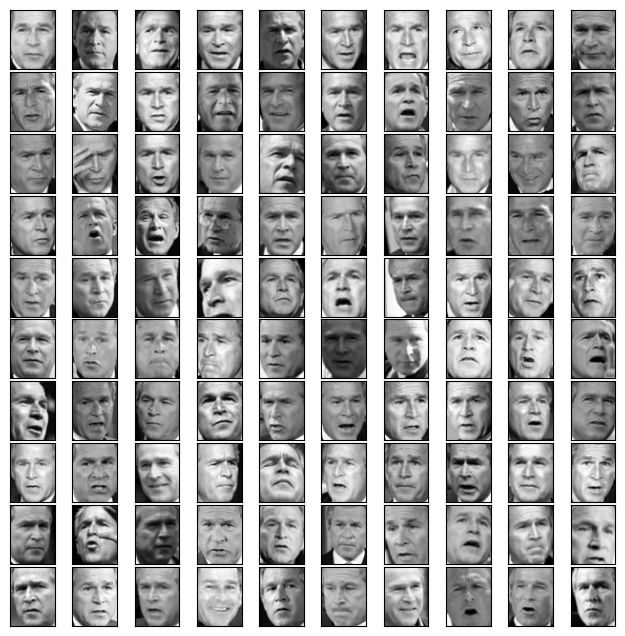

In [56]:
def plot_faces(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i], cmap='gray')
plot_faces(faces.images)

### The Dimensionality Challenge

 We have N images, and each image has M pixels:
  - N = {N} samples
  - M = {M} dimensions

This presents a classic case of the "curse of dimensionality" where N < M:
 - The number of samples is smaller than the dimension
 - This makes statistical learning challenging
 - Dimensionality reduction becomes crucial for effective modeling

## Understanding Principal Component Analysis (PCA)

PCA is a dimensionality reduction technique that transforms high-dimensional data into a lower-dimensional space while preserving as much variance as possible. Key concepts include:

 1. **Principal Components**: These are the directions in the data that capture the most variation. In our context, each principal component is an "eigenface" - a base face that, when combined with others, can reconstruct real faces.

 2. **Variance Explained**: This measures how much of the original data's variability we retain after dimensionality reduction. Each principal component captures some variance, and we want to keep enough components to maintain the important features while reducing noise.

 3. **Whitening**: This transforms the data to have uncorrelated components with unit variance, which is particularly helpful for subsequent modeling steps.

We define a helper function that will plot our PCA-transformed data:
- Shows data points in 2D space
- Optionally displays thumbnail images at data points
- Helps visualize how PCA organizes the images in 2D space

## Applying PCA for Dimension Reduction
  
 We'll use PCA to:
  1. Reduce dimensions from {M} to 120
  2. Keep the most important facial features
  3. Make the modeling problem tractable
  4. Whiten the data for better subsequent modeling

In [57]:
pca = PCA(n_components=120, whiten=True)
data = pca.fit_transform(faces.images.reshape(N,-1))

print("Original shape:", faces.images.reshape(N,-1).shape)
print("Reduced shape:", data.shape)

Original shape: (530, 2914)
Reduced shape: (530, 120)


In [58]:
# Check how much variance we've retained
variance_retained = pca.explained_variance_ratio_.sum()
print(f"Percentage of variance retained: {variance_retained*100:.2f}%")

Percentage of variance retained: 94.59%


### Understanding the Explained Variance Ratio

 The cumulative explained variance ratio ({variance_retained*100:.2f}%) tells us how much of the original data's variability we've retained after dimensionality reduction. This is crucial for face generation:

  - Higher ratio (>80%): Better reconstruction, more detail preserved
  - Lower ratio (<70%): More information loss, potentially blurry faces
  - Too high (>95%): May preserve noise and overfit

 Our choice of 120 components balances information retention against model complexity.

## Next Steps

 Now that we have reduced our face data to a manageable dimensionality while preserving the most important features, we can proceed to:

  1. Model the distribution of faces in this reduced space using Gaussian Mixture Models (GMM)
  2. Generate new faces by sampling from this distribution
  3. Transform the samples back to image space

 These steps will be covered in the next notebook (GMM.py).

## Key Takeaways

 1. Face images, while high-dimensional ({M} pixels), have inherent structure that PCA can capture
 2. We reduced dimensionality from {M} to 120 while retaining {variance_retained*100:.2f}% of the variance
 3. This reduction makes subsequent modeling more tractable
 4. The whitened PCA space provides a good foundation for generative modeling